# My Model

Let:
$$
\begin{aligned}
\mathbf{x}(t) &= \begin{bmatrix} x(t) \\ y(t) \\ z(t) \end{bmatrix} \quad \text{(position vector)} \\
\boldsymbol{\omega} &= \begin{bmatrix} \omega_x \\ \omega_y \\ \omega_z \end{bmatrix} \quad \text{(spin vector)} \\
\mathbf{v}(t) &= \begin{bmatrix} v_x(t) \\ v_y(t) \\ v_z(t) \end{bmatrix} \quad \text{(velocity vector)}
\end{aligned}
$$

Where the $z$ axis is the vertical axis.

## Attributes

### 1. Reynolds Number
$$
\text{Re} = \frac{\rho \cdot \|\mathbf{v}\|}{\mu}
$$

### 2. Spin Factor
$$
S = \frac{r \cdot \|\boldsymbol{\omega}\|}{\|\mathbf{v}\|}
$$

### 3. Dynamic Drag Coefficient
$$
C_D = C_{D0} + k_1 \cdot S
$$

### 4. Dynamic Lift Coefficient
$$
C_L = \frac{C_{L0} \cdot S}{1 + S}
$$

## Forces

### 1. Gravity
$$
\mathbf{F}_g = m \begin{bmatrix} 0 \\ 0 \\ -g \end{bmatrix}
$$

### 2. Drag Force
$$
\mathbf{F}_D = -\frac{1}{2} \rho C_D A \|\mathbf{v}\| \mathbf{v}
$$

### 3. Magnus (Lift) Force
$$
\mathbf{F}_L = \frac{1}{2} \rho C_L A \|\mathbf{v}\| \mathbf{v}
$$

## Equations of Motion

$$
\frac{d\mathbf{v}}{dt} = \frac{\mathbf{F}_g + \mathbf{F}_D + \mathbf{F}_L}{m}
$$

$$
\frac{d\boldsymbol{\omega}}{dt} = -\frac{\boldsymbol{\omega}}{\tau}
$$

$$
\frac{d\mathbf{r}}{dt} = \mathbf{v}
$$

## Typical Constants

\begin{align*}
m &= 0.0459 \, \text{kg} \quad &\text{(mass of golf ball)} \\
R &= 0.02135 \, \text{m} \quad &\text{(radius)} \\
A &= \pi R^2 \, \text{m}^2 \quad &\text{(cross-sectional area)} \\
g &= 9.81 \, \text{m/s}^2 \quad &\text{(gravity)} \\
\rho &= 1.225 \, \text{kg/m}^3 \quad &\text{(air density)} \\
\mu &\approx 1.8 \times 10^{−5} \, \text{kg/(m}\cdot\text{s)} \\
C_{D0} &\approx 0.25 \quad &\text{(base drag coefficient)} \\
k_1 &\approx 0.2 \quad &\text{(empirically tuned constant)} \\
C_{L0} &\approx 0.2 \quad &\text{(base lift coefficient)} \\
\end{align*}

## Example Initial Conditions

$$
\mathbf{v}(0) = \begin{bmatrix} 70 \\ 0 \\ 20 \end{bmatrix} \quad \text{m/s}
\qquad
\boldsymbol{\omega} = \begin{bmatrix} 0 \\ 200 \\ 0 \end{bmatrix} \quad \text{rad/s}
$$

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
g = 9.81  # gravity (m/s^2)
rho = 1.225  # air density (kg/m^3)  [should be for 14.69 psi, 50% humidity, 77F]
Cd = 0.25  # drag coefficient (typical for a golf ball)
Cl = 0.2   # lift coefficient (varies with spin and speed)
r = 0.02135  # radius of golf ball (m)
A = np.pi * r**2  # cross-sectional area
m = 0.04593  # mass of golf ball (kg)

# Magnus force scalar factor
S = 0.5 * rho * Cl * A * r

# ODE system
def golfball_dynamics(t, y, spin_rate, spin_axis):
    pos = y[0:3]
    vel = y[3:6]
    v_mag = np.linalg.norm(vel)

    omega = generate_spin_vector(spin_rate, spin_axis)
    
    # Forces
    F_gravity = np.array([0, 0, -g])
    F_drag = -0.5 * rho * Cd * A * v_mag * vel / m
    F_magnus = S * np.cross(omega, vel) / m

    acc = F_gravity + F_drag + F_magnus

    return np.concatenate((vel, acc))

# Converting spin rate and axis to vector
def generate_spin_vector(spin_rate, spin_axis):
    axis_rad = np.radians(spin_axis)

    # Magnitude of spin vector in rad/s
    omega_mag = spin_rate * 2 * np.pi / 60  # convert to rad/s

    # Tilted from y-axis in x–z plane
    omega_x = 0 # spin lies in y-z plane (tilted from y)
    omega_y = omega_mag * np.cos(axis_rad)
    omega_z = omega_mag * np.sin(axis_rad)  

    return np.array([omega_x, omega_y, omega_z])

# Converting from polar to cartesian coordinates
def generate_velocity_vector(ball_speed, launch_direction, launch_angle):
    v_x = ball_speed * np.cos(launch_direction) * np.cos(launch_angle)
    v_y = ball_speed * np.sin(launch_direction) * np.cos(launch_angle)
    v_z = ball_speed * np.sin(launch_angle)
    return np.array([v_x, v_y, v_z])

convert_mph_to_mps = lambda mph: mph * 1609.344 / 3600
convert_meters_to_yards = lambda yards: yards * 1250 / 1143

In [4]:
import pandas as pd

# Collecting the data
justin_data = pd.read_csv("trackman-csv-export-20230807.Normalized.csv", skiprows = [0,2])
justin_data_trackman = justin_data[['Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis', 'Max Height - Dist.',
       'Max Height - Height', 'Max Height - Side', 'Carry Flat - Length', 'Carry Flat - Side',
       'Carry Flat - Land. Angle', 'Carry Flat - Ball Speed',
       'Carry Flat - Time', 'Impact Offset',
       'Impact Height', 'Curve']].dropna(how='any', subset=['Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis'])
print(justin_data_trackman.to_string())

    Ball Speed  Launch Angle  Launch Direction    Spin Rate  Spin Axis  Max Height - Dist.  Max Height - Height  Max Height - Side  Carry Flat - Length  Carry Flat - Side  Carry Flat - Land. Angle  Carry Flat - Ball Speed  Carry Flat - Time  Impact Offset  Impact Height      Curve
0   104.415493         1.611             8.912  8571.439323     34.533          135.673651             3.363416          31.123670            71.673969          19.752288                  5.567416                65.153859           1.798472            NaN            NaN  26.520767
1    94.170989        16.233            12.840  7053.390494     30.857          208.617658            41.712246          67.676247           114.035257          46.080229                 32.938061                49.218917           4.099488     -33.427211       3.533387  65.241468
2    93.346008        10.190            15.484  4792.940483     39.666          158.241127            17.144196          54.683348            91.862694   

In [3]:
from datetime import datetime
jgj_cols = ['Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis', 'Max Height', 'Total Carry', 'Straight Carry', 'Sideways Carry', 'Carry time']
justin_data_jgj = []
for j,row in justin_data_trackman.iterrows():
    #("working on row", j, "at time", datetime.now(), "has time of:", row['Carry Flat - Time'])
    if j == 32:
        print(row)
    current_row = [row[element] for element in ('Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis')]
    
    v0 = generate_velocity_vector(convert_mph_to_mps(row['Ball Speed']), row['Launch Angle'], row['Launch Direction'])  # initial velocity (m/s) - forward, side, upward
    
    # Initial state vector: [x, y, z, vx, vy, vz]
    y0 = np.concatenate((np.zeros(3), v0))

    # Time span
    t_span = (0, int(row['Carry Flat - Time'] + 2))
    t_eval = np.linspace(*t_span, 1000)

    # Solve ODE
    sol = solve_ivp(golfball_dynamics, t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-9, args = (row['Spin Rate'], row['Spin Axis']))

    for i in range(len(sol.t)):
        if sol.y[2,i] < 0:
            end_time = i
            break

    current_row.append(convert_meters_to_yards(np.max(sol.y[2]))/3) # Max height
    current_row.append(convert_meters_to_yards(np.sqrt(sol.y[0,i] ** 2 + sol.y[1,i]**2))) # Carry total
    current_row.append(convert_meters_to_yards(sol.y[0,i])) # Carry straight
    current_row.append(convert_meters_to_yards(sol.y[1,i])) # Carry Sideways
    current_row.append(sol.t[i]) # Carry time
    justin_data_jgj.append(current_row)

justin_data_jgj = pd.DataFrame(justin_data_jgj, columns=jgj_cols)

NameError: name 'justin_data_trackman' is not defined

In [38]:
comparison = justin_data_jgj.copy()
comparison['Max Height'] = comparison['Max Height'] - justin_data['Max Height - Height']
comparison['Total Carry'] = comparison['Total Carry'] - np.sqrt(np.power(justin_data['Carry Flat - Length'], 2) + np.power(justin_data['Carry Flat - Side'], 2))
comparison['Straight Carry'] = comparison['Straight Carry'] - justin_data['Carry Flat - Length']
comparison['Sideways Carry'] = comparison['Sideways Carry'] - justin_data['Carry Flat - Side']
comparison['Carry time'] = comparison['Carry time'] - justin_data['Carry Flat - Time']

print(comparison.to_string())

    Ball Speed  Launch Angle  Launch Direction    Spin Rate  Spin Axis  Max Height  Total Carry  Straight Carry  Sideways Carry  Carry time
0   104.415493         1.611             8.912  8571.439323     34.533    4.064529    29.536384      -59.061973     -122.866125    1.201528
1    94.170989        16.233            12.840  7053.390494     30.857  -39.239817   -32.041339     -190.873789      -94.743921   -1.558947
2    93.346008        10.190            15.484  4792.940483     39.666  -15.822391   -35.508429      -46.708213        7.341682   -1.064820
3   109.786371        19.051             0.646  5819.000320     -0.306  -73.458618   -16.444391      -19.100445       25.693361   -1.240617
4   112.558160        18.141            -3.730  5505.660117     -8.542  -71.334129    -2.794924     -279.198796      129.597459   -0.432130
5   109.386409        18.044            -0.014  5703.649821     -2.004  -78.129905  -154.387870     -154.482424        2.248243   -5.601471
6   106.323814      

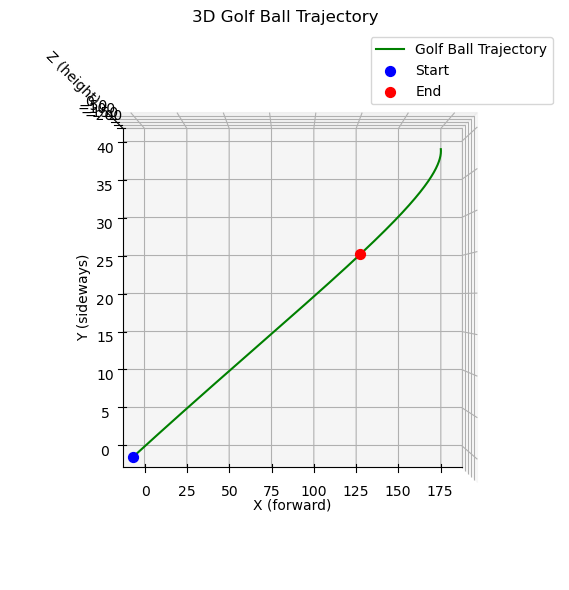

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(sol.y[0], sol.y[1], sol.y[2], label='Golf Ball Trajectory', color='green')

# Mark the start and end
ax.scatter(sol.y[0][0], sol.y[1][0], sol.y[2][0], color='blue', label='Start', s=50)
ax.scatter(sol.y[0][end_time], sol.y[1][end_time], sol.y[2][end_time], color='red', label='End', s=50)

# Labels and title
ax.set_xlabel('X (forward)')
ax.set_ylabel('Y (sideways)')
ax.set_zlabel('Z (height)')
ax.set_title('3D Golf Ball Trajectory')
ax.legend()

# Set viewing angle (optional)
ax.view_init(elev=90, azim=-90
             )

plt.tight_layout()
plt.show()


# Paper 1 Model

## General notation
The reference coordinate system used for the physics model has the X axis pointing away from a right-handed golfer, the Y axis pointing at the target, and the Z axis pointing towards the sky.

A three-dimensional vector $\vec{u} \in \mathbb{R}^3$ points in the direction $\hat{u} = \frac{\vec{u}}{\|\vec{u}\|}$. A continuous time series of $\vec{u}$ vectors is denoted as $\vec{u}(t)$. A discrete time step $i$ of $\vec{u}(t)$ is denoted as $\vec{u}_i$ and has components $u_{i,x}$, $u_{i,y}$, and $u_{i,z}$

## Physics Model
The ball hass mass $m$, radius $R$, position $\vec{r}(t)$, velocity $\vec{v}(t)$, and spin $\vec{\omega}(t)$.

We have the following ODE:
\begin{align}
    \frac{d\vec{v}(t)}{dt} &= \frac{\vec{F}(t)}{m} \\
    \frac{d\vec{\omega}(t)}{dt} &= \frac{\vec{T}(t)}{I}
\end{align}

Where:
\begin{align}
    I &= \frac{2}{5}mR^2 \\
    q &= \frac{1}{2}\rho \|\vec{v}\|^2 \\
    \vec{F}_L &= C_L q A \frac{\vec{v} \times \vec{\omega}}{\| \vec{v} \times \vec{\omega} \|} \\
    \vec{F}_D &= -C_D q A \hat{v} \\
    \vec{T} &= -C_M q d A \hat{\omega} \\
    \vec{F} &= \vec{F}_L + \vec{F}_D + \vec{G}
\end{align}

And:
\begin{align}
    S &= \frac{R\| \vec{\omega} \|}{\|\vec{v}\|} \\
    C_L &= p_1 + p_2 S + p_3 S^2 \\
    C_D &= p_4 + p_5 S + p_6 S^2 \\
    C_M &= p_7 S
\end{align}

# Paper 2 Model

## Given equations:

\begin{align}
    S &= \frac{r\Omega}{v}, &\text{spin ratio} \\
    C_D &= a + bS + cS^2, &\text{drag coefficient} \\
    C_L &= d + eS + fS^2, &\text{lift coefficient} \\
    C_M &= gS, &\text{moment coefficient} 
\end{align}

## Constants:

\begin{align}
    r &= \text{ball radius} \\
    \Omega &= \text{total angular speed} \\
    v &= \text{total linear speed}
\end{align}

Unknown constants were labelled $a$ through $g$.

Constants $a$ through $f$ were bounded between +2 and -2, while $g$ was bounded between 0.010 and 0.015 to reflect realistic spin decay. The constants were found to be {0.1304, 0.9287, -0.8259, 0.0504, 1.2031, -1.1490, 0.01}, respectively.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

# Constants
rho = 1.225         # air density (kg/m^3)
A = np.pi * 0.02135**2   # cross-sectional area for a golf ball radius ~0.02135 m
d = 0.0427          # golf ball diameter (m)
g = 9.81            # gravitational acceleration
params = [0.1304, 0.9287, -0.8259, 0.0504, 1.2031, -1.1490, 0.01]
p1, p2, p3, p4, p5, p6, p7 = params

# Ball properties
m = 0.04593  # mass (kg)
R = 0.02135  # radius (m)
I = (2/5) * m * R**2  # moment of inertia

# Converting spin rate and axis to vector
def generate_spin_vector(spin_rate, spin_axis):
    axis_rad = np.radians(spin_axis)

    # Magnitude of spin vector in rad/s
    omega_mag = spin_rate * 2 * np.pi / 60  # convert to rad/s

    # Tilted from y-axis in x–z plane
    omega_x = omega_mag * np.cos(axis_rad)
    omega_y = 0 # spin lies in y-z plane (tilted from y)
    omega_z = omega_mag * np.sin(axis_rad)  

    return np.array([omega_x, omega_y, omega_z])

# Converting from polar to cartesian coordinates
def generate_velocity_vector(ball_speed, launch_direction, launch_angle):
    v_x = ball_speed * np.cos(launch_angle) * np.sin(launch_direction)
    v_y = ball_speed * np.cos(launch_direction) * np.cos(launch_angle)
    v_z = ball_speed * np.sin(launch_angle)
    return np.array([v_x, v_y, v_z])

convert_mph_to_mps = lambda mph: mph * 1609.344 / 3600
convert_meters_to_yards = lambda yards: yards * 1250 / 1143

def dynamics(t, y):
    # Unpack state vector
    r = y[0:3]
    v = y[3:6]
    w = y[6:9]

    v_norm = np.linalg.norm(v)
    w_norm = np.linalg.norm(w)

    if v_norm == 0 or w_norm == 0:
        cross_vw = np.zeros(3)
        cross_norm = 1  # avoid division by zero
    else:
        cross_vw = np.cross(v, w)
        cross_norm = np.linalg.norm(cross_vw)

    S = (R * w_norm) / (v_norm + 1e-8)  # spin ratio (avoid div by 0)

    # Coefficients
    C_L = p1 + p2*S + p3*S**2
    C_D = p4 + p5*S + p6*S**2
    C_M = p7*S

    # Dynamic pressure
    q = 0.5 * rho * v_norm**2

    # Forces
    F_L = C_L * q * A * (cross_vw / (cross_norm + 1e-8))
    F_D = -C_D * q * A * (v / (v_norm + 1e-8))
    F_G = np.array([0, -m*g, 0])
    F = F_L + F_D + F_G

    # Torques
    T = -C_M * q * d * A * (w / (w_norm + 1e-8))

    # Derivatives
    drdt = v
    dvdt = F / m
    dwdt = T / I

    return np.concatenate([drdt, dvdt, dwdt])

# Initial conditions
# r0 = np.array([0, 0, 0])
# v0 = np.array([50, 10, 5])        # initial velocity (m/s)
# w0 = np.array([0, 0, 200])        # initial spin (rad/s)
# y0 = np.concatenate([r0, v0, w0])

# # Time span
# t_span = (0, 5)
# t_eval = np.linspace(*t_span, 1000)

# Solve ODE
#sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-9)

# sol.t: time points
# sol.y[0:3, :]: position over time
# sol.y[3:6, :]: velocity over time
# sol.y[6:9, :]: angular velocity over time


In [7]:
from datetime import datetime
jgj_cols = ['Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis', 'Max Height', 'Total Carry', 'Straight Carry', 'Sideways Carry', 'Carry time']
justin_data_jgj = []
for j,row in justin_data_trackman.iterrows():
    #("working on row", j, "at time", datetime.now(), "has time of:", row['Carry Flat - Time'])
    current_row = [row[element] for element in ('Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis')]
    
    v0 = generate_velocity_vector(convert_mph_to_mps(row['Ball Speed']), row['Launch Angle'], row['Launch Direction'])  # initial velocity (m/s) - forward, side, upward
    omega0 = generate_spin_vector(row['Spin Rate'], row['Spin Axis'])

    # Initial state vector
    y0 = np.concatenate((np.zeros(3), v0, omega0))

    # Time span
    t_span = (0, int(row['Carry Flat - Time'] + 2))
    t_eval = np.linspace(*t_span, 1000)

    # Solve ODE
    sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-9)

    for i in range(len(sol.t)):
        if sol.y[2,i] < 0:
            end_time = i
            break

    current_row.append(convert_meters_to_yards(np.max(sol.y[2]))*3) # Max height
    current_row.append(convert_meters_to_yards(np.sqrt(sol.y[0,i] ** 2 + sol.y[1,i]**2))) # Carry total
    current_row.append(convert_meters_to_yards(sol.y[0,i])) # Carry straight
    current_row.append(convert_meters_to_yards(sol.y[1,i])) # Carry Sideways
    current_row.append(sol.t[i]) # Carry time
    justin_data_jgj.append(current_row)

justin_data_jgj = pd.DataFrame(justin_data_jgj, columns=jgj_cols)

print(justin_data_jgj)

    Ball Speed  Launch Angle  Launch Direction    Spin Rate  Spin Axis  \
0   104.415493         1.611             8.912  8571.439323     34.533   
1    94.170989        16.233            12.840  7053.390494     30.857   
2    93.346008        10.190            15.484  4792.940483     39.666   
3   109.786371        19.051             0.646  5819.000320     -0.306   
4   112.558160        18.141            -3.730  5505.660117     -8.542   
5   109.386409        18.044            -0.014  5703.649821     -2.004   
6   106.323814        18.855             7.410  6145.311097     13.058   
7    95.652735        19.584             7.803  6067.340724     14.887   
8   110.625674        18.602            -2.681  5592.669280     -6.519   
9    82.084822        18.121            19.009  8601.480328     38.031   
10  110.556775        19.438            -1.457  5994.839674      1.276   
11  101.437010        16.738            -3.849  4878.999406    -14.777   
12  107.866634        18.416          

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
grav = 9.81  # gravity (m/s^2)
rho = 1.137  # air density (kg/m^3)
r = 0.02135  # radius of golf ball (m)
d = 2 * r    # diameter
A = np.pi * r**2  # cross-sectional area
m = 0.04593  # mass of golf ball (kg)
I = 2/5 * m * r**2  # moment of inertia

# Aerodynamic coefficients from paper_2.pdf
a = 0.1304
b = 0.9287
c = -0.8259
d = 0.0504
e = 1.2031
f = -1.1490
g = 0.01

# Helper functions
def spin_ratio(linear_speed, angular_speed):
    """Calculate spin ratio with safety checks"""
    if linear_speed < 0.1:  # prevent division by zero
        return 0
    return r * angular_speed / linear_speed

def C_D(s_val):
    return a + b * s_val + c * s_val**2

def C_L(s_val):
    return d + e * s_val + f * s_val**2

def C_M(s_val):
    return g * s_val

def mph_to_mps(mph):
    """Convert mph to m/s"""
    return mph * 0.44704

def rpm_to_radps(rpm):
    """Convert rpm to rad/s"""
    return rpm * 2 * np.pi / 60

# ODE system
def golfball_dynamics(t, y):
    """Differential equations for golf ball flight"""
    pos = y[0:3]
    vel = y[3:6]
    spin = y[6:9]
    
    v_mag = np.linalg.norm(vel)
    spin_mag = np.linalg.norm(spin)
    
    # Safety checks for zero velocity/spin
    if v_mag < 0.1:
        return np.zeros(9)
    
    q = 0.5 * rho * v_mag**2
    s_val = spin_ratio(v_mag, spin_mag)
    
    # Unit vectors
    v_hat = vel / v_mag if v_mag > 0 else np.zeros(3)
    spin_hat = spin / spin_mag if spin_mag > 0 else np.zeros(3)
    
    # Cross product for Magnus direction
    if spin_mag > 0:
        cross_prod = np.cross(spin, vel)
        cross_mag = np.linalg.norm(cross_prod)
        magnus_dir = cross_prod / cross_mag if cross_mag > 0 else np.zeros(3)
    else:
        magnus_dir = np.zeros(3)
    
    # Forces and torque
    F_gravity = np.array([0, 0, -m * grav])
    F_drag = -C_D(s_val) * q * A * v_hat
    F_magnus = C_L(s_val) * q * A * magnus_dir
    T = -C_M(s_val) * q * d * A * spin_hat
    
    # Derivatives
    dvdt = (F_gravity + F_drag + F_magnus) / m
    dwdt = T / I
    drdt = vel
    
    return np.concatenate((drdt, dvdt, dwdt))

def generate_spin_vector(spin_rate_rpm, spin_axis_deg):
    """Generate spin vector from rate (rpm) and axis (degrees)"""
    omega_mag = rpm_to_radps(spin_rate_rpm)
    axis_rad = np.radians(spin_axis_deg)
    
    # Assuming spin axis is measured from vertical (z-axis)
    omega_x = omega_mag * np.sin(axis_rad)
    omega_y = 0  # Assuming no sidespin component in this simple case
    omega_z = omega_mag * np.cos(axis_rad)
    
    return np.array([omega_x, omega_y, omega_z])

def generate_velocity_vector(ball_speed_mph, launch_angle_deg, azimuth_deg=0):
    """Generate velocity vector from launch parameters"""
    ball_speed = mph_to_mps(ball_speed_mph)
    launch_angle = np.radians(launch_angle_deg)
    azimuth = np.radians(azimuth_deg)
    
    v_x = ball_speed * np.sin(azimuth) * np.cos(launch_angle)
    v_y = ball_speed * np.cos(azimuth) * np.cos(launch_angle)
    v_z = ball_speed * np.sin(launch_angle)
    
    return np.array([v_x, v_y, v_z])

def simulate_golf_shot(ball_speed_mph=160, launch_angle_deg=12, 
                      spin_rate_rpm=2500, spin_axis_deg=0,
                      initial_height=0, azimuth_deg=0, 
                      t_end=10, max_step=0.01):
    """Run a complete golf shot simulation"""
    # Initial conditions
    v0 = generate_velocity_vector(ball_speed_mph, launch_angle_deg, azimuth_deg)
    omega0 = generate_spin_vector(spin_rate_rpm, spin_axis_deg)
    y0 = np.concatenate((
        [0, 0, initial_height],  # position
        v0,                     # velocity
        omega0                  # spin
    ))
    
    # Solve ODE
    sol = solve_ivp(
        golfball_dynamics,
        [0, t_end],
        y0,
        method='RK45',
        max_step=max_step,
        vectorized=False
    )
    
    return sol


# # Run a simulation
# if __name__ == "__main__":
#     # Example: Driver shot
#     sol = simulate_golf_shot(
#         ball_speed_mph=94.170989,       # 160 mph ball speed
#         launch_angle_deg=16.233,      # 12 degree launch angle
#         spin_rate_rpm=7053.390494,       # 2500 rpm backspin
#         spin_axis_deg=30.857,          # 0 = pure backspin, 90 = pure sidespin
#         initial_height=0,      # Tee height (1 cm)
#         azimuth_deg=12.840,            # No sidespin (straight shot)
#         t_end=7,                  # Simulate for 7 seconds
#         max_step=0.01             # Maximum time step
#     )
    
#     # Plot results
#     plot_trajectory_3d(sol)
    
#     # Print carry distance
#     carry_idx = np.argmax(sol.y[2] < 0)
#     if carry_idx > 0:
#         carry_distance = np.sqrt(sol.y[0][carry_idx]**2 + sol.y[1][carry_idx]**2)
#         print(f"Carry distance: {carry_distance:.1f} m ({carry_distance * 1.09361:.1f} yards)")

    Ball Speed  Launch Angle  Launch Direction    Spin Rate  Spin Axis  Max Height  Total Carry  Straight Carry  Sideways Carry  Carry time
0   104.415493         1.611             8.912  8571.439323     34.533    0.944927    36.382920       36.297077        2.497808    0.800527
1    94.170989        16.233            12.840  7053.390494     30.857   30.150544    98.304365       98.256882       -3.055071    3.190584
2    93.346008        10.190            15.484  4792.940483     39.666   14.595678    83.759852       83.271576        9.030915    2.399589
3   109.786371        19.051             0.646  5819.000320     -0.306   33.568270   104.568188      100.624257      -28.447582    2.875501
4   112.558160        18.141            -3.730  5505.660117     -8.542   28.846740    99.066435       94.084998      -31.018891    2.541489
5   109.386409        18.044            -0.014  5703.649821     -2.004   29.675775    99.875386       96.304792      -26.466576    2.678495
6   106.323814      

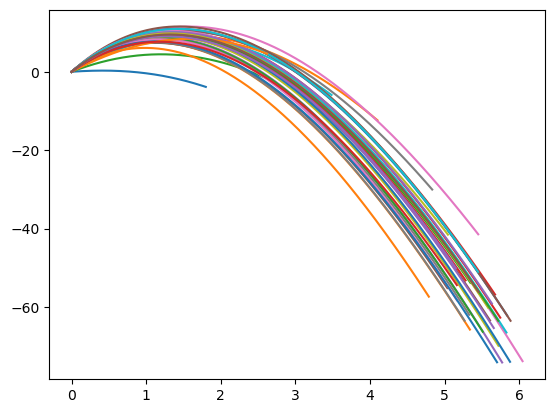

In [23]:
from datetime import datetime

convert_mph_to_mps = lambda mph: mph * 1609.344 / 3600
convert_meters_to_yards = lambda meters: meters * 1250 / 1143

jgj_cols = ['Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis', 'Max Height', 'Total Carry', 'Straight Carry', 'Sideways Carry', 'Carry time']
justin_data_jgj = []
for j,row in justin_data_trackman.iterrows():
    #("working on row", j, "at time", datetime.now(), "has time of:", row['Carry Flat - Time'])
    current_row = [row[element] for element in ('Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis')]


    # Solve ODE
    sol = simulate_golf_shot(
        ball_speed_mph=row['Ball Speed'],       # 160 mph ball speed
        launch_angle_deg=row['Launch Angle'],      # 12 degree launch angle
        spin_rate_rpm=row['Spin Rate'],       # 2500 rpm backspin
        spin_axis_deg=row['Spin Axis'],          # 0 = pure backspin, 90 = pure sidespin
        initial_height=0,      # Tee height (1 cm)
        azimuth_deg=row['Launch Direction'],            # No sidespin (straight shot)
        t_end=row['Carry Flat - Time'],                  # Simulate for 7 seconds
        max_step=0.001             # Maximum time step
    )

    carry_idx = np.argmax(sol.y[2] < 0)

    plt.plot(sol.t, sol.y[2])

    current_row.append(convert_meters_to_yards(np.max(sol.y[2]))*3) # Max height (ft)
    current_row.append(convert_meters_to_yards(np.sqrt(sol.y[0,carry_idx] ** 2 + sol.y[1,carry_idx]**2))) # Carry total
    current_row.append(convert_meters_to_yards(sol.y[1,carry_idx])) # Carry straight
    current_row.append(convert_meters_to_yards(sol.y[0,carry_idx])) # Carry Sideways
    current_row.append(sol.t[carry_idx]) # Carry time
    justin_data_jgj.append(current_row)

justin_data_jgj = pd.DataFrame(justin_data_jgj, columns=jgj_cols)

#print(justin_data_jgj)
print(justin_data_jgj.to_string())

comparison = justin_data_jgj.copy()
comparison['Max Height'] = (comparison['Max Height'] - justin_data['Max Height - Height']) / justin_data['Max Height - Height']
comparison['Total Carry'] = (comparison['Total Carry'] - np.sqrt(np.power(justin_data['Carry Flat - Length'], 2) + np.power(justin_data['Carry Flat - Side'], 2))) / np.sqrt(np.power(justin_data['Carry Flat - Length'], 2) + np.power(justin_data['Carry Flat - Side'], 2))
comparison['Straight Carry'] = (comparison['Straight Carry'] - justin_data['Carry Flat - Length']) / justin_data['Carry Flat - Length']
comparison['Sideways Carry'] = (comparison['Sideways Carry'] - justin_data['Carry Flat - Side']) / justin_data['Carry Flat - Side']
comparison['Carry time'] = (comparison['Carry time'] - justin_data['Carry Flat - Time']) / justin_data['Carry Flat - Time']

print(comparison.to_string())

In [29]:
from scipy.optimize import minimize
import pandas as pd

def objective(theta):
    a, b, c, d, e, f, g = theta
    total_error = 0
    
    for j, row in justin_data.iterrows():
        if j == 32:
            continue
        # Override the global coefficients
        globals()['a'], globals()['b'], globals()['c'] = a, b, c
        globals()['d'], globals()['e'], globals()['f'] = d, e, f
        globals()['g'] = g
        
        try:
            sol = simulate_golf_shot(
                ball_speed_mph=row['Ball Speed'],
                launch_angle_deg=row['Launch Angle'],
                spin_rate_rpm=row['Spin Rate'],
                spin_axis_deg=row['Spin Axis'],
                initial_height=0,
                azimuth_deg=row['Launch Direction'],
                t_end=row['Carry Flat - Time'],
                max_step=0.01
            )

            carry_idx = np.argmax(sol.y[2] < 0)
            if carry_idx == 0:
                continue  # simulation may not have landed
            
            sim_max_height = convert_meters_to_yards(np.max(sol.y[2])) * 3  # feet
            sim_total_carry = convert_meters_to_yards(np.sqrt(sol.y[0, carry_idx] ** 2 + sol.y[1, carry_idx]**2))
            sim_straight = convert_meters_to_yards(sol.y[1, carry_idx])
            sim_side = convert_meters_to_yards(sol.y[0, carry_idx])
            sim_time = sol.t[carry_idx]

            # Error terms
            e1 = (sim_max_height - row['Max Height - Height']) ** 2
            e2 = (sim_total_carry - np.hypot(row['Carry Flat - Length'], row['Carry Flat - Side'])) ** 2
            e3 = (sim_straight - row['Carry Flat - Length']) ** 2
            e4 = (sim_side - row['Carry Flat - Side']) ** 2
            e5 = (sim_time - row['Carry Flat - Time']) ** 2

            total_error += e2
        
        except Exception as err:
            print(f"Simulation failed on row {j}: {err}")
            total_error += 1000  # penalize failures
    
    return total_error


initial_guess = [0.13, 0.92, -0.82, 0.05, 1.2, -1.14, 0.01]
bounds = [
    (-2, 2),   # a
    (-2, 2),    # b
    (-2, 2),       # c
    (-2, 2),   # d
    (-2, 2),      # e
    (-2, 2),       # f
    (0.01, 0.015),      # g
]

from scipy.optimize import differential_evolution

result = differential_evolution(objective, bounds)

#result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

print("Best fit parameters:", result.x)


Best fit parameters: [-1.91042926 -1.97164387 -0.72989213  1.35108549  0.04028373 -1.47218412
  0.01068411]


    Ball Speed  Launch Angle  Launch Direction    Spin Rate  Spin Axis   Max Height  Total Carry  Straight Carry  Sideways Carry  Carry time
0   104.415493         1.611             8.912  8571.439323     34.533   323.819667          0.0             0.0             0.0         0.0
1    94.170989        16.233            12.840  7053.390494     30.857   879.802822          0.0             0.0             0.0         0.0
2    93.346008        10.190            15.484  4792.940483     39.666   741.212327          0.0             0.0             0.0         0.0
3   109.786371        19.051             0.646  5819.000320     -0.306   900.995419          0.0             0.0             0.0         0.0
4   112.558160        18.141            -3.730  5505.660117     -8.542   863.820118          0.0             0.0             0.0         0.0
5   109.386409        18.044            -0.014  5703.649821     -2.004   827.928743          0.0             0.0             0.0         0.0
6   106.32381

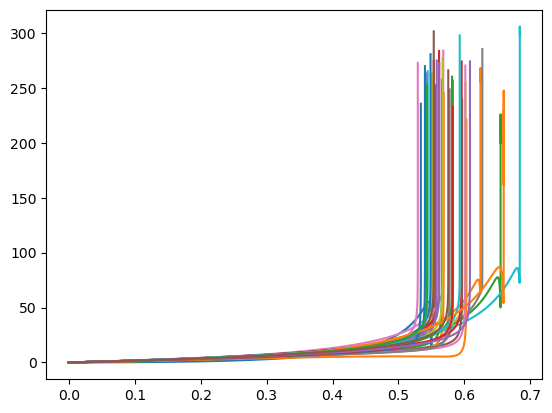

In [5]:
globals()['a'], globals()['b'], globals()['c'], globals()['d'], globals()['e'], globals()['f'], globals()['g'] = -2, -2, -2, -2, 2, 0.61768585, 0.015

globals()['a'], globals()['b'], globals()['c'], globals()['d'], globals()['e'], globals()['f'], globals()['g'] = -1.91042926, -1.97164387, -0.72989213,  1.35108549,  0.04028373, -1.47218412, 0.01068411

from datetime import datetime

convert_mph_to_mps = lambda mph: mph * 1609.344 / 3600
convert_meters_to_yards = lambda meters: meters * 1250 / 1143

jgj_cols = ['Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis', 'Max Height', 'Total Carry', 'Straight Carry', 'Sideways Carry', 'Carry time']
justin_data_jgj = []
for j,row in justin_data_trackman.iterrows():
    #("working on row", j, "at time", datetime.now(), "has time of:", row['Carry Flat - Time'])
    current_row = [row[element] for element in ('Ball Speed', 'Launch Angle', 'Launch Direction',
       'Spin Rate', 'Spin Axis')]


    # Solve ODE
    sol = simulate_golf_shot(
        ball_speed_mph=row['Ball Speed'],       # 160 mph ball speed
        launch_angle_deg=row['Launch Angle'],      # 12 degree launch angle
        spin_rate_rpm=row['Spin Rate'],       # 2500 rpm backspin
        spin_axis_deg=row['Spin Axis'],          # 0 = pure backspin, 90 = pure sidespin
        initial_height=0,      # Tee height (1 cm)
        azimuth_deg=row['Launch Direction'],            # No sidespin (straight shot)
        t_end=row['Carry Flat - Time'],                  # Simulate for 7 seconds
        max_step=0.001             # Maximum time step
    )

    carry_idx = np.argmax(sol.y[2] < 0)

    plt.plot(sol.t, sol.y[2])

    current_row.append(convert_meters_to_yards(np.max(sol.y[2]))*3) # Max height (ft)
    current_row.append(convert_meters_to_yards(np.sqrt(sol.y[0,carry_idx] ** 2 + sol.y[1,carry_idx]**2))) # Carry total
    current_row.append(convert_meters_to_yards(sol.y[1,carry_idx])) # Carry straight
    current_row.append(convert_meters_to_yards(sol.y[0,carry_idx])) # Carry Sideways
    current_row.append(sol.t[carry_idx]) # Carry time
    justin_data_jgj.append(current_row)

justin_data_jgj = pd.DataFrame(justin_data_jgj, columns=jgj_cols)

#print(justin_data_jgj)
print(justin_data_jgj.to_string())

comparison = justin_data_jgj.copy()
comparison['Max Height'] = (comparison['Max Height'] - justin_data['Max Height - Height']) / justin_data['Max Height - Height']
comparison['Total Carry'] = (comparison['Total Carry'] - np.sqrt(np.power(justin_data['Carry Flat - Length'], 2) + np.power(justin_data['Carry Flat - Side'], 2))) / np.sqrt(np.power(justin_data['Carry Flat - Length'], 2) + np.power(justin_data['Carry Flat - Side'], 2))
comparison['Straight Carry'] = (comparison['Straight Carry'] - justin_data['Carry Flat - Length']) / justin_data['Carry Flat - Length']
comparison['Sideways Carry'] = (comparison['Sideways Carry'] - justin_data['Carry Flat - Side']) / justin_data['Carry Flat - Side']
comparison['Carry time'] = (comparison['Carry time'] - justin_data['Carry Flat - Time']) / justin_data['Carry Flat - Time']

print(comparison.to_string())